# Reconstruction

This notebook provides comprehensive information on how to reconstruct modalities. We displays examples of 3D MRIs reconstructions and how to obtain them as well as random sampling mask. 

# Playing with reconstructions

In [104]:
# necessary imports
import os

import matplotlib.pyplot as plt
import torch
from monai.data import Dataset
from torch.utils.data import DataLoader

from bmmae.augmentations import get_val_transforms
from bmmae.decoders import Decoder
from bmmae.model import BMMAE
from bmmae.tokenizers import MRITokenizer
from bmmae.utils import visualize_multimodal_3d

In [105]:
modalities = ["t1", "t1ce", "t2", "flair"]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

tokenizers = {
    modality: MRITokenizer(patch_size=(16, 16, 16), img_size=(128, 128, 128), hidden_size=768)
    for modality in modalities
}
decoder = Decoder(
        decoder_hidden_size=384,
        num_layers=3,
        mlp_dim=1536,
        dropout_rate=0.,
        num_heads=12,
        qkv_bias=True,
        img_size=(128, 128, 128),
        patch_size=(16, 16, 16),
    )

reconstructor = BMMAE(modalities, tokenizers, decoder)
reconstructor.load_state_dict(torch.load("pretrained_models/bmmae.pth", map_location="cpu", weights_only=True))
reconstructor.to(device)
reconstructor.eval()

BMMAE(
  (tokenizers): ModuleDict(
    (t1): MRITokenizer(
      (patch_embedding): PatchEmbeddingBlock(
        (patch_embeddings): Conv3d(1, 768, kernel_size=(16, 16, 16), stride=(16, 16, 16))
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (t1ce): MRITokenizer(
      (patch_embedding): PatchEmbeddingBlock(
        (patch_embeddings): Conv3d(1, 768, kernel_size=(16, 16, 16), stride=(16, 16, 16))
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (t2): MRITokenizer(
      (patch_embedding): PatchEmbeddingBlock(
        (patch_embeddings): Conv3d(1, 768, kernel_size=(16, 16, 16), stride=(16, 16, 16))
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (flair): MRITokenizer(
      (patch_embedding): PatchEmbeddingBlock(
        (patch_embeddings): Conv3d(1, 768, kernel_size=(16, 16, 16), stride=(16, 16, 16))
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (decoder): Decoder(
    (decoder_embed): Linear(in_features=76

In [106]:
val_patients = os.listdir("../rsna/BraTS2021/val")
val_files = [
    {
        modality: os.path.join("../rsna/BraTS2021/val", patient, f"{patient}_{modality}.nii.gz")
        for modality in modalities
    }
    for patient in val_patients
]
transforms_val = get_val_transforms(modalities)
dataset = Dataset(val_files, transforms_val)
dataloader = DataLoader(dataset, batch_size=1, num_workers=6, shuffle=False, pin_memory=True)

In [107]:
# take first batch
batch = next(iter(dataloader))
batch = {mod: batch[mod].to(device) for mod in batch}
mask = {mod: torch.zeros(batch["flair"].shape[0], 512).to(device) for mod in modalities}
# mask t1 to reconstruct
mask["t1"].fill_(1)
with torch.no_grad():
    outputs, _ = reconstructor(batch, modality_masks=mask)

In [ ]:
visualize_multimodal_3d(outputs, batch, mask)
plt.show()

In [8]:
# same but reconstruct everything from t1ce
mask = {mod: torch.zeros(batch["flair"].shape[0], 512).to(device) for mod in modalities}
mask["t1"].fill_(1)
mask["t2"].fill_(1)
mask["flair"].fill_(1)
with torch.no_grad():
    outputs, _ = reconstructor(batch, modality_masks=mask)

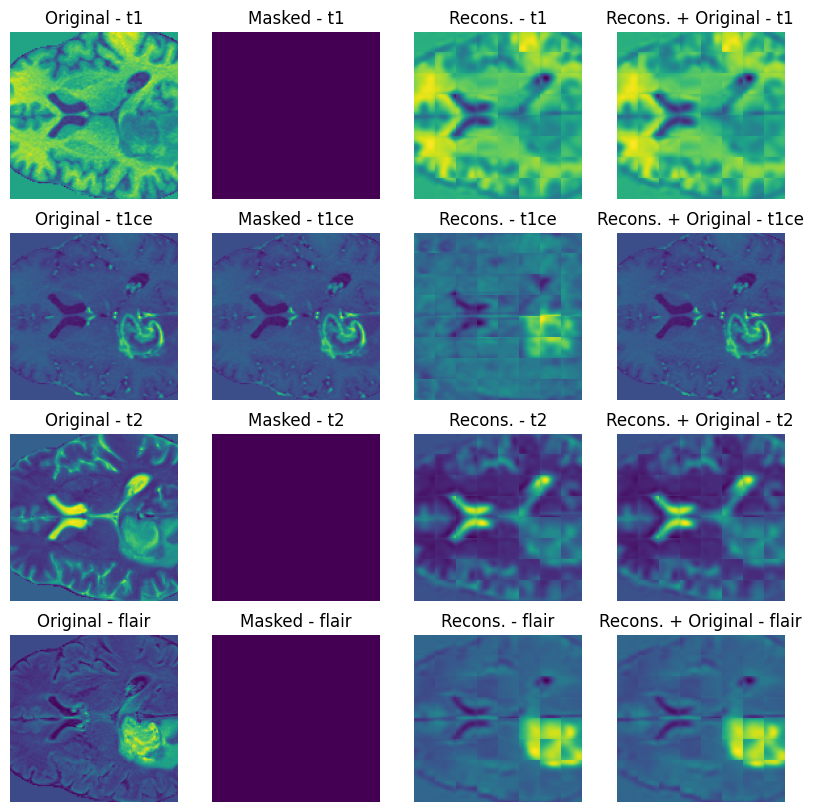

In [9]:
visualize_multimodal_3d(outputs, batch, mask)
plt.show()